In [1]:
from romatch import roma_outdoor, roma_indoor

roma_model = roma_indoor(device="cuda:0")
roma_model.upsample_preds = False
roma_model.symmetric = False

/root/miniconda3/envs/testMonoGS/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/testMonoGS/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)


Matching took 2.792 seconds
somewhatsomehow
(10000, 2)


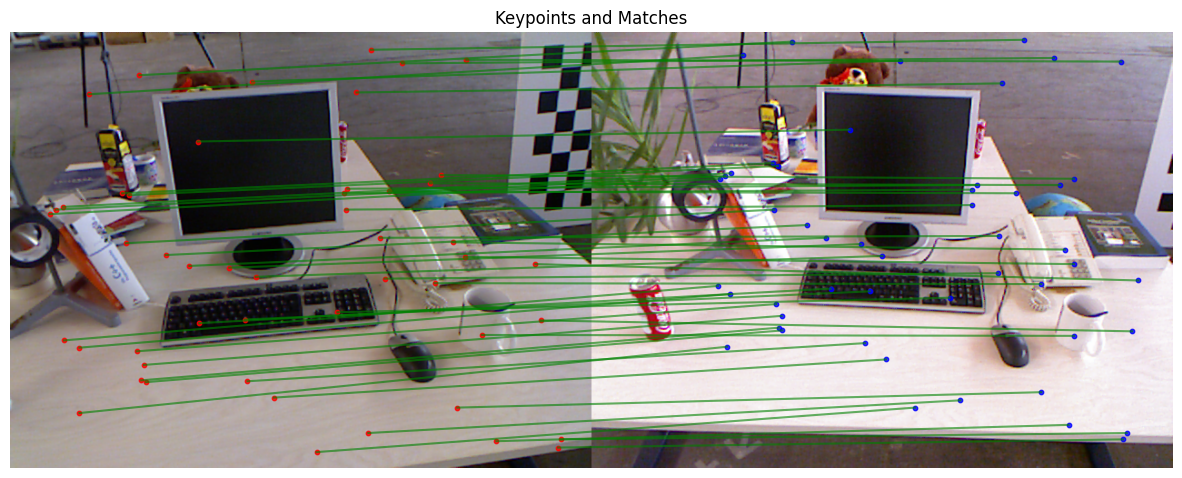

In [2]:
import torch
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

imA = np.array(Image.open("datasets/tum/rgbd_dataset_freiburg2_xyz/rgb/1311867170.462290.png"))
H,W = imA.shape[:2]
# imA = (imA * 255).astype(np.uint8)
imA = Image.fromarray(imA)


imB = np.array(Image.open("datasets/tum/rgbd_dataset_freiburg2_xyz/rgb/1311867220.809727.png"))
# imB = (imB * 255).astype(np.uint8)
imB = Image.fromarray(imB)


start_time = time.time()

for i in range(10):
    warp, certainty_warp = roma_model.match(
        imA, imB, device="cuda:0"
    )

matches, certainty = roma_model.sample(warp, certainty_warp)


certainty = certainty_warp.reshape(-1).clone()
certainty[certainty > 0.8] = 1
good_samples = torch.multinomial(certainty, 10000, replacement=False)
matches_NN = warp.reshape(-1,4)[good_samples]

kptsA = matches_NN[:, :2]
kptsB = matches_NN[:, 2:]

kptsA_pix = torch.zeros_like(kptsA)
kptsB_pix = torch.zeros_like(kptsB)
kptsA_pix[:,0] = ((kptsA[:,0] + 1) * (W - 1) / 2)
kptsA_pix[:,1] = ((kptsA[:,1] + 1) * (H - 1) / 2)

kptsB_pix[:,0] = ((kptsB[:,0] + 1) * (W - 1) / 2)
kptsB_pix[:,1] = ((kptsB[:,1] + 1) * (H - 1) / 2)

kptsA_idx = np.round(kptsA_pix.detach().cpu().numpy()).astype(np.int32)
kptsB_idx = np.round(kptsB_pix.detach().cpu().numpy()).astype(np.int32)

elapsed_time = time.time() - start_time
print(f"Matching took {elapsed_time:.3f} seconds")

# Combine images A and B into a single plot and connect corresponding keypoints
combined_width = W * 2
combined_height = H

# Create a blank canvas for the combined image
combined_image = Image.new('RGB', (combined_width, combined_height))
combined_image.paste(imA, (0, 0))
combined_image.paste(imB, (W, 0))

plt.figure(figsize=(15, 7))
plt.imshow(combined_image)


print("somewhatsomehow")
print(kptsB_idx.shape)
# Adjust keypoints for the combined image
kptsB_idx_shifted = kptsB_idx.copy()
kptsB_idx_shifted[:, 0] += W  # Shift keypoints B horizontally

# Plot and connect keypoints
for i in range(0, 50):  # Example: plotting a subset of keypoints
    plt.plot(
        [kptsA_idx[i, 0], kptsB_idx_shifted[i, 0]],
        [kptsA_idx[i, 1], kptsB_idx_shifted[i, 1]],
        'g-', alpha=0.6
    )
    plt.scatter(kptsA_idx[i, 0], kptsA_idx[i, 1], c='r', s=10, alpha=0.8)
    plt.scatter(kptsB_idx_shifted[i, 0], kptsB_idx_shifted[i, 1], c='b', s=10, alpha=0.8)

plt.axis('off')
plt.title("Keypoints and Matches")
plt.savefig("keypoints_combined.png", dpi=300)